# CHAPTER 12. CUSTOM MODELS AND TRAINING WITH TENSORFLOW
Up until now, we’ve used only TensorFlow’s high-level API, Keras, but it already got us pretty far: we built various neural network architectures, including regression and classification nets, Wide & Deep nets, and self-normalizing nets, using all sorts of techniques, such as batch normalization, dropout, and learning rate schedules. In fact, 95% of the use cases you will encounter will not require anything other than Keras (and tf.data; see Chapter 13). But now it’s time to dive deeper into TensorFlow and take a look at its lower-level Python API. This will be useful when you need extra control to write custom loss functions, custom metrics, layers, models, initializers, regularizers, weight constraints, and more. You may even need to fully control the training loop itself; for example, to apply special transformations or constraints to the gradients (beyond just clipping them) or to use multiple optimizers for different parts of the network. We will cover all these cases in this chapter, and we will also look at how you can boost your custom models and training algorithms using TensorFlow’s automatic graph generation feature. But first, let’s take a quick tour of TensorFlow.


# A QUICK TOUR OF TENSORFLOW
As you know, TensorFlow is a powerful library for numerical computation, particularly well suited and fine-tuned for large-scale machine learning (but you can use it for anything else that requires heavy computations). It was developed by the Google Brain team and it powers many of Google’s large-scale services, such as Google Cloud Speech, Google Photos, and Google Search. It was open sourced in November 2015, and it is now the most widely used deep learning library in the industry: countless projects use TensorFlow for all sorts of machine learning tasks, such as image classification, natural language processing, recommender systems, and time series forecasting.

So what does TensorFlow offer? Here’s a summary:

- Its core is very similar to NumPy, but with GPU support.

- It supports distributed computing (across multiple devices and servers).

- It includes a kind of just-in-time (JIT) compiler that allows it to optimize computations for speed and memory usage. It works by extracting the computation graph from a Python function, optimizing it (e.g., by pruning unused nodes), and running it efficiently (e.g., by automatically running independent operations in parallel).

- Computation graphs can be exported to a portable format, so you can train a TensorFlow model in one environment (e.g., using Python on Linux) and run it in another (e.g., using Java on an Android device).

- It implements reverse-mode autodiff (see Chapter 10 and Appendix B) and provides some excellent optimizers, such as RMSProp and Nadam (see Chapter 11), so you can easily minimize all sorts of loss functions.

TensorFlow offers many more features built on top of these core features: the most important is of course Keras, but it also has data loading and preprocessing ops (tf.data, tf.io, etc.), image processing ops (tf.image), signal processing ops (tf.signal), and more (see Figure 12-1 for an overview of TensorFlow’s Python API).

TIP
We will cover many of the packages and functions of the TensorFlow API, but it’s impossible to cover them all, so you should really take some time to browse through the API; you will find that it is quite rich and well documented.

At the lowest level, each TensorFlow operation (op for short) is implemented using highly efficient C++ code. Many operations have multiple implementations called kernels: each kernel is dedicated to a specific device type, such as CPUs, GPUs, or even TPUs (tensor processing units). As you may know, GPUs can dramatically speed up computations by splitting them into many smaller chunks and running them in parallel across many GPU threads. TPUs are even faster: they are custom ASIC chips built specifically for deep learning operations (we will discuss how to use TensorFlow with GPUs or TPUs in Chapter 19).

Figure 12-1. TensorFlow’s Python API
![tenorflow_python_api](../images/tenorflow_python_api.png)

TensorFlow’s architecture is shown in Figure 12-2. Most of the time your code will use the high-level APIs (especially Keras and tf.data), but when you need more flexibility you will use the lower-level Python API, handling tensors directly. In any case, TensorFlow’s execution engine will take care of running the operations efficiently, even across multiple devices and machines if you tell it to.

TensorFlow runs not only on Windows, Linux, and macOS, but also on mobile devices (using TensorFlow Lite), including both iOS and Android (see Chapter 19). Note that APIs for other languages are also available, if you do not want to use the Python API: there are C++, Java, and Swift APIs. There is even a JavaScript implementation called TensorFlow.js that makes it possible to run your models directly in your browser.

Figure 12-2. TensorFlow’s architecture
![tensorflows_architecture](../images/tensorflows_architecture.png)

There’s more to TensorFlow than the library. TensorFlow is at the center of an extensive ecosystem of libraries. First, there’s TensorBoard for visualization (see Chapter 10). Next, there’s TensorFlow Extended (TFX), which is a set of libraries built by Google to productionize TensorFlow projects: it includes tools for data validation, preprocessing, model analysis, and serving (with TF Serving; see Chapter 19). Google’s TensorFlow Hub provides a way to easily download and reuse pretrained neural networks. You can also get many neural network architectures, some of them pretrained, in TensorFlow’s model garden. Check out the TensorFlow Resources and https://github.com/jtoy/awesome-tensorflow for more TensorFlow-based projects. You will find hundreds of TensorFlow projects on GitHub, so it is often easy to find existing code for whatever you are trying to do.

TIP
More and more ML papers are released along with their implementations, and sometimes even with pretrained models. Check out https://paperswithcode.com to easily find them.

Last but not least, TensorFlow has a dedicated team of passionate and helpful developers, as well as a large community contributing to improving it. To ask technical questions, you should use https://stackoverflow.com and tag your question with tensorflow and python. You can file bugs and feature requests through GitHub. For general discussions, join the TensorFlow Forum.

OK, it’s time to start coding!

# USING TENSORFLOW LIKE NUMPY
TensorFlow’s API revolves around tensors, which flow from operation to operation—hence the name TensorFlow. A tensor is very similar to a NumPy ndarray: it is usually a multidimensional array, but it can also hold a scalar (a simple value, such as 42). These tensors will be important when we create custom cost functions, custom metrics, custom layers, and more, so let’s see how to create and manipulate them.

**Tensors and operations**
You can create a tensor with tf.constant(). For example, here is a tensor representing a matrix with two rows and three columns of floats:

In [716]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

t = tf.constant([[1., 2., 3.], [4., 5., 6.]])  # matrix
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

Just like an ndarray, a tf.Tensor has a shape and a data type (dtype):

In [717]:
t.shape


TensorShape([2, 3])

In [718]:
t.dtype

tf.float32

Indexing works much like in NumPy:

In [719]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [720]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

Most importantly, all sorts of tensor operations are available:

In [721]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [722]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [723]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

Note that writing t + 10 is equivalent to calling tf.add(t, 10) (indeed, Python calls the magic method `t.__add__(10)`, which just calls tf.add(t, 10)). Other operators, like - and *, are also supported. The @ operator was added in Python 3.5, for matrix multiplication: it is equivalent to calling the tf.matmul() function.

NOTE
Many functions and classes have aliases. For example, tf.add() and tf.math.add() are the same function. This allows TensorFlow to have concise names for the most common operations while preserving well-organized packages.

A tensor can also hold a scalar value. In this case, the shape is empty:

In [724]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

NOTE
The Keras API has its own low-level API, located in tf.keras.backend. This package is usually imported as K, for conciseness. It used to include functions like K.square(), K.exp(), and K.sqrt(), which you may run across in existing code: this was useful to write portable code back when Keras supported multiple backends, but now that Keras is TensorFlow-only, you should call TensorFlow’s low-level API directly (e.g., tf.square() instead of K.square()). Technically K.square() and its friends are still there for backward compatibility, but the documentation of the tf.keras.backend package only lists a handful of utility functions, such as clear_session() (mentioned in Chapter 10).

Keras's low-level API:

In [725]:
K = tf.keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

But since Keras does not support multiple backends anymore, you should instead use TF's low-level API directly:

In [726]:
tf.square(tf.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

You will find all the basic math operations you need (tf.add(), tf.multiply(), tf.square(), tf.exp(), tf.sqrt(), etc.) and most operations that you can find in NumPy (e.g., tf.reshape(), tf.squeeze(), tf.tile()). Some functions have a different name than in NumPy; for instance, tf.reduce_mean(), tf.reduce_sum(), tf.reduce_max(), and tf.math.log() are the equivalent of np.mean(), np.sum(), np.max(), and np.log(). When the name differs, there is usually a good reason for it. For example, in TensorFlow you must write tf.transpose(t); you cannot just write t.T like in NumPy. The reason is that the tf.transpose() function does not do exactly the same thing as NumPy’s T attribute: in TensorFlow, a new tensor is created with its own copy of the transposed data, while in NumPy, t.T is just a transposed view on the same data. Similarly, the tf.reduce_sum() operation is named this way because its GPU kernel (i.e., GPU implementation) uses a reduce algorithm that does not guarantee the order in which the elements are added: because 32-bit floats have limited precision, the result may change ever so slightly every time you call this operation. The same is true of tf.reduce_mean() (but of course tf.reduce_max() is deterministic).

**Tensors and NumPy**
Tensors play nice with NumPy: you can create a tensor from a NumPy array, and vice versa. You can even apply TensorFlow operations to NumPy arrays and NumPy operations to tensors:

In [727]:
import numpy as np

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [728]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [729]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [730]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

WARNING
Notice that NumPy uses 64-bit precision by default, while TensorFlow uses 32-bit. This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. So when you create a tensor from a NumPy array, make sure to set dtype=tf.float32.

**Type conversions**
Type conversions can significantly hurt performance, and they can easily go unnoticed when they are done automatically. To avoid this, TensorFlow does not perform any type conversions automatically: it just raises an exception if you try to execute an operation on tensors with incompatible types. For example, you cannot add a float tensor and an integer tensor, and you cannot even add a 32-bit float and a 64-bit float:

In [731]:
try:
    tf.constant(2.) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 


In [732]:
try:
    tf.constant(2.) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


This may be a bit annoying at first, but remember that it’s for a good cause! And of course you can use tf.cast() when you really need to convert types:

In [733]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

**Variables**
The tf.Tensor values we’ve seen so far are immutable: we cannot modify them. This means that we cannot use regular tensors to implement weights in a neural network, since they need to be tweaked by backpropagation. Plus, other parameters may also need to change over time (e.g., a momentum optimizer keeps track of past gradients). What we need is a tf.Variable:

In [734]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

A tf.Variable acts much like a tf.Tensor: you can perform the same operations with it, it plays nicely with NumPy as well, and it is just as picky with types. But it can also be modified in place using the assign() method (or assign_add() or assign_sub(), which increment or decrement the variable by the given value). You can also modify individual cells (or slices), by using the cell’s (or slice’s) assign() method or by using the scatter_update() or scatter_nd_update() methods:

In [735]:
v.assign(2 * v)  # v now equals [[2., 4., 6.], [8., 10., 12.]]

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [736]:
v[0, 1].assign(42)  # v now equals [[2., 42., 6.], [8., 10., 12.]]

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [737]:
v[:, 2].assign([0., 1.])  # v now equals [[2., 42., 0.], [8., 10., 1.]]

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [738]:
v.scatter_nd_update(  # v now equals [[100., 42., 0.], [8., 10., 200.]]
    indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [739]:
# extra code – shows how to use scatter_update()
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

Direct assignment will not work:

In [740]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


NOTE
In practice you will rarely have to create variables manually; Keras provides an add_weight() method that will take care of it for you, as you’ll see. Moreover, model parameters will generally be updated directly by the optimizers, so you will rarely need to update variables manually.

**Other data structures**
TensorFlow supports several other data structures, including the following (see the “Other Data Structures” section in this chapter’s notebook or Appendix C for more details):

- Sparse tensors (tf.SparseTensor)
Efficiently represent tensors containing mostly zeros. The tf.sparse package contains operations for sparse tensors.

- Tensor arrays (tf.TensorArray)
Are lists of tensors. They have a fixed length by default but can optionally be made extensible. All tensors they contain must have the same shape and data type.

- Ragged tensors (tf.RaggedTensor)
Represent lists of tensors, all of the same rank and data type, but with varying sizes. The dimensions along which the tensor sizes vary are called the ragged dimensions. The tf.ragged package contains operations for ragged tensors.

- String tensors
Are regular tensors of type tf.string. These represent byte strings, not Unicode strings, so if you create a string tensor using a Unicode string (e.g., a regular Python 3 string like "café"), then it will get encoded to UTF-8 automatically (e.g., b"caf\xc3\xa9"). Alternatively, you can represent Unicode strings using tensors of type tf.int32, where each item represents a Unicode code point (e.g., [99, 97, 102, 233]). The tf.strings package (with an s) contains ops for byte strings and Unicode strings (and to convert one into the other). It’s important to note that a tf.string is atomic, meaning that its length does not appear in the tensor’s shape. Once you convert it to a Unicode tensor (i.e., a tensor of type tf.int32 holding Unicode code points), the length appears in the shape.

- Sets
Are represented as regular tensors (or sparse tensors). For example, tf.constant([[1, 2], [3, 4]]) represents the two sets {1, 2} and {3, 4}. More generally, each set is represented by a vector in the tensor’s last axis. You can manipulate sets using operations from the tf.sets package.

- Queues
Store tensors across multiple steps. TensorFlow offers various kinds of queues: basic first-in, first-out (FIFO) queues (FIFOQueue), plus queues that can prioritize some items (PriorityQueue), shuffle their items (RandomShuffleQueue), and batch items of different shapes by padding (PaddingFIFOQueue). These classes are all in the tf.queue package.

With tensors, operations, variables, and various data structures at your disposal, you are now ready to customize your models and training algorithms!

**STRINGS**

In [741]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [742]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [743]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [744]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [745]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

**STRING ARRAYS**


In [746]:

tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [747]:

tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [748]:

u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [749]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [750]:
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [751]:

tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [752]:

p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [753]:

tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [754]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

**RAGGED TENSORS**


In [755]:
r[1]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 67, 111, 102, 102, 101, 101])>

In [756]:
r[1:3]  # extra code – a slice of a ragged tensor is a ragged tensor

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>

In [757]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
tf.concat([r, r2], axis=0)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>

In [758]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [759]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

**SPARSE TENSORS**

In [760]:

s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [761]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [762]:
s * 42.0

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([ 42.  84. 126.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))

In [763]:
try:
    s + 42.0
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [764]:
# extra code – shows how to multiply a sparse tensor and a dense tensor
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [765]:
# extra code – when creating a sparse tensor, values must be given in "reading
#              order", or else `to_dense()` will fail.
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],  # WRONG ORDER!
                     values=[1., 2.],
                     dense_shape=[3, 4])
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense] name: 


In [766]:
# extra code – shows how to fix the sparse tensor s5 by reordering its values
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

**TENSOR ARRAYS**


In [767]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
tensor1 = array.read(1)  # returns (and zeros out!) tf.constant([3., 10.])

In [768]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [769]:

# extra code – shows how to disable clear_after_read
array2 = tf.TensorArray(dtype=tf.float32, size=3, clear_after_read=False)
array2 = array2.write(0, tf.constant([1., 2.]))
array2 = array2.write(1, tf.constant([3., 10.]))
array2 = array2.write(2, tf.constant([5., 7.]))
tensor2 = array2.read(1)  # returns tf.constant([3., 10.])
array2.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.,  2.],
       [ 3., 10.],
       [ 5.,  7.]], dtype=float32)>

In [770]:
# extra code – shows how to create and use a tensor array with a dynamic size
array3 = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
array3 = array3.write(0, tf.constant([1., 2.]))
array3 = array3.write(1, tf.constant([3., 10.]))
array3 = array3.write(2, tf.constant([5., 7.]))
tensor3 = array3.read(1)
array3.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

**SETS**


In [771]:
a = tf.constant([[1, 5, 9]])
b = tf.constant([[5, 6, 9, 11]])
u = tf.sets.union(a, b)
u

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]], shape=(5, 2), dtype=int64), values=tf.Tensor([ 1  5  6  9 11], shape=(5,), dtype=int32), dense_shape=tf.Tensor([1 5], shape=(2,), dtype=int64))

In [772]:

tf.sparse.to_dense(u)

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 1,  5,  6,  9, 11]])>

In [773]:

a = tf.constant([[1, 5, 9], [10, 0, 0]])
b = tf.constant([[5, 6, 9, 11], [13, 0, 0, 0]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13,  0,  0]])>

In [774]:
# extra code – shows how to use a different default value: -1 in this case
a = tf.constant([[1, 5, 9], [10, -1, -1]])
b = tf.constant([[5, 6, 9, 11], [13, -1, -1, -1]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u, default_value=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [-1, 10, 13, -1, -1]])>

In [775]:
# extra code – shows how to use `tf.sets.difference()`
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]])>

In [776]:
# extra code – shows how to use `tf.sets.difference()`
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

In [777]:
# extra code – check whether set1[0] contains 5
tf.sets.size(tf.sets.intersection(set1[:1], tf.constant([[5, 0, 0, 0]]))) > 0

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

**QUEUES**

In [778]:
q = tf.queue.FIFOQueue(3, [tf.int32, tf.string], shapes=[(), ()])
q.enqueue([10, b"windy"])
q.enqueue([15, b"sunny"])
q.size()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [779]:
q.dequeue()

[<tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'windy'>]

In [780]:

q.enqueue_many([[13, 16], [b'cloudy', b'rainy']])

In [781]:
q.dequeue_many(3)

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([15, 13, 16])>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'sunny', b'cloudy', b'rainy'], dtype=object)>]

# CUSTOMIZING MODELS AND TRAINING ALGORITHMS
You’ll start by creating a custom loss function, which is a straightforward and common use case.

**Custom loss function**
Suppose you want to train a regression model, but your training set is a bit noisy. Of course, you start by trying to clean up your dataset by removing or fixing the outliers, but that turns out to be insufficient; the dataset is still noisy. Which loss function should you use? The mean squared error might penalize large errors too much and cause your model to be imprecise. The mean absolute error would not penalize outliers as much, but training might take a while to converge, and the trained model might not be very precise. This is probably a good time to use the Huber loss (introduced in Chapter 10) instead of the good old MSE. The Huber loss is available in Keras (just use an instance of the tf.keras.losses.Huber class), but let’s pretend it’s not there. To implement it, just create a function that takes the labels and the model’s predictions as arguments, and uses TensorFlow operations to compute a tensor containing all the losses (one per sample):

In [782]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

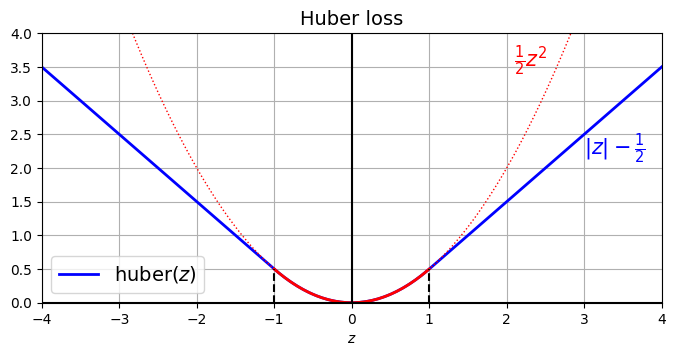

In [783]:
# extra code – shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

WARNING
For better performance, you should use a vectorized implementation, as in this example. Moreover, if you want to benefit from TensorFlow’s graph optimization features, you should use only TensorFlow operations.

It is also possible to return the mean loss instead of the individual sample losses, but this is not recommended as it makes it impossible to use class weights or sample weights when you need them (see Chapter 10).

Now you can use this Huber loss function when you compile the Keras model, then train your model as usual:


To test our custom loss function, let's create a basic Keras model and train it on the California housing dataset:

In [784]:
# extra code – loads, splits and scales the California housing dataset, then
#              creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [785]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.4858 - mae: 0.8357 - val_loss: 0.3479 - val_mae: 0.6527
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2415 - mae: 0.5419 - val_loss: 0.2630 - val_mae: 0.5473


And that’s it! For each batch during training, Keras will call the huber_fn() function to compute the loss, then it will use reverse-mode autodiff to compute the gradients of the loss with regard to all the model parameters, and finally it will perform a gradient descent step (in this example using a Nadam optimizer). Moreover, it will keep track of the total loss since the beginning of the epoch, and it will display the mean loss.

But what happens to this custom loss when you save the model?

**Saving and Loading Models That Contain Custom Components**
Saving a model containing a custom loss function works fine, but when you load it, you’ll need to provide a dictionary that maps the function name to the actual function. More generally, when you load a model containing custom objects, you need to map the names to the objects:



In [786]:
model.save("saved_models/my_model_with_a_custom_loss")  # extra code – saving works

INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss\assets


In [787]:
model = tf.keras.models.load_model("saved_models/my_model_with_a_custom_loss",
                                   custom_objects={"huber_fn": huber_fn})

In [788]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2052 - mae: 0.4910 - val_loss: 0.2210 - val_mae: 0.4946
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1888 - mae: 0.4683 - val_loss: 0.2021 - val_mae: 0.4773


TIP
If you decorate the huber_fn() function with @keras.utils.register_keras_serializable(), it will automatically be available to the load_model() function: there’s no need to include it in the custom_objects dictionary.

With the current implementation, any error between –1 and 1 is considered “small”. But what if you want a different threshold? One solution is to create a function that creates a configured loss function:

In [789]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    return huber_fn


In [790]:

model.compile(loss=create_huber(2.0), optimizer="nadam")

In [791]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2051 - val_loss: 0.2249
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2035


Unfortunately, when you save the model, the threshold will not be saved. This means that you will have to specify the threshold value when loading the model (note that the name to use is "huber_fn", which is the name of the function you gave Keras, not the name of the function that created it):

In [792]:
model.save("saved_models/my_model_with_a_custom_loss_threshold_2")

INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss_threshold_2\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss_threshold_2\assets


In [793]:
model = tf.keras.models.load_model(
    "saved_models/my_model_with_a_custom_loss_threshold_2",
    custom_objects={"huber_fn": create_huber(2.0)}
)

In [794]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.1935 - val_loss: 0.2020
Epoch 2/2
363/363 [==============================] - 0s 995us/step - loss: 0.1899 - val_loss: 0.1867


You can solve this by creating a subclass of the tf.keras.losses.Loss class, and then implementing its get_config() method:

In [795]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

Let’s walk through this code:

- The constructor accepts **kwargs and passes them to the parent constructor, which handles standard hyperparameters: the name of the loss and the reduction algorithm to use to aggregate the individual instance losses. By default this is "AUTO", which is equivalent to "SUM_OVER_BATCH_SIZE": the loss will be the sum of the instance losses, weighted by the sample weights, if any, and divided by the batch size (not by the sum of weights, so this is not the weighted mean). Other possible values are "SUM" and "NONE".

- The call() method takes the labels and predictions, computes all the instance losses, and returns them.

- The get_config() method returns a dictionary mapping each hyperparameter name to its value. It first calls the parent class’s get_config() method, then adds the new hyperparameters to this dictionary.

You can then use any instance of this class when you compile the model:

In [796]:

# extra code – creates another basic Keras model
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [797]:
model.compile(loss=HuberLoss(2.), optimizer="nadam")

In [798]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.6492 - val_loss: 0.5093
Epoch 2/2
363/363 [==============================] - 0s 989us/step - loss: 0.2912 - val_loss: 0.3715


When you save the model, the threshold will be saved along with it; and when you load the model, you just need to map the class name to the class itself:

In [799]:
model.save("saved_models/my_model_with_a_custom_loss_class")  # extra code – saving works

INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss_class\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_loss_class\assets


In [800]:
model = tf.keras.models.load_model("saved_models/my_model_with_a_custom_loss_class",
                                   custom_objects={"HuberLoss": HuberLoss})

In [801]:
# extra code – shows that loading worked fine, the model can be used normally
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2416 - val_loss: 0.2922
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.2173 - val_loss: 0.2503


In [802]:
model.loss.threshold  # extra code – the treshold was loaded correctly

2.0

When you save a model, Keras calls the loss instance’s get_config() method and saves the config in the SavedModel format. When you load the model, it calls the from_config() class method on the HuberLoss class: this method is implemented by the base class (Loss) and creates an instance of the class, passing **config to the constructor.

That’s it for losses! As you’ll see now, custom activation functions, initializers, regularizers, and constraints are not much different.

**Custom Activation Functions, Initializers, Regularizers, and Constraints**
Most Keras functionalities, such as losses, regularizers, constraints, initializers, metrics, activation functions, layers, and even full models, can be customized in much the same way. Most of the time, you will just need to write a simple function with the appropriate inputs and outputs. Here are examples of a custom activation function (equivalent to tf.keras.activations.softplus() or tf.nn.softplus()), a custom Glorot initializer (equivalent to tf.keras.initializers.glorot_normal()), a custom ℓ1 regularizer (equivalent to tf.keras.regularizers.l1(0.01)), and a custom constraint that ensures weights are all positive (equivalent to tf.keras.​con⁠straints.nonneg() or tf.nn.relu()):

In [803]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))


def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)


def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))


def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

As you can see, the arguments depend on the type of custom function. These custom functions can then be used normally, as shown here:

In [804]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [805]:

# extra code – show that building, training, saving, loading, and training again
#              works fine with a model containing many custom parts

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_initializer=my_glorot_initializer,
                          kernel_regularizer=my_l1_regularizer,
                          kernel_constraint=my_positive_weights)
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("saved_models/my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "saved_models/my_model_with_many_custom_parts",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.4714 - mae: 0.8316 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 986us/step - loss: 0.8094 - mae: 0.6172 - val_loss: 2.6153 - val_mae: 0.6058
INFO:tensorflow:Assets written to: saved_models/my_model_with_many_custom_parts\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_many_custom_parts\assets


Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.6333 - mae: 0.5617 - val_loss: 1.1687 - val_mae: 0.5468
Epoch 2/2
363/363 [==============================] - 0s 995us/step - loss: 0.5570 - mae: 0.5303 - val_loss: 1.0440 - val_mae: 0.5250


The activation function will be applied to the output of this Dense layer, and its result will be passed on to the next layer. The layer’s weights will be initialized using the value returned by the initializer. At each training step the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. Finally, the constraint function will be called after each training step, and the layer’s weights will be replaced by the constrained weights.

If a function has hyperparameters that need to be saved along with the model, then you will want to subclass the appropriate class, such as tf.keras.regularizers.Regularizer, tf.keras.constraints.Constraint, tf.keras.initializers.Initializer, or tf.keras.layers.Layer (for any layer, including activation functions). Much as you did for the custom loss, here is a simple class for ℓ1 regularization that saves its factor hyperparameter (this time you do not need to call the parent constructor or the get_config() method, as they are not defined by the parent class):

In [806]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

In [807]:

# extra code – again, show that everything works fine, this time using our
#              custom regularizer class

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1, activation=my_softplus,
                          kernel_regularizer=MyL1Regularizer(0.01),
                          kernel_constraint=my_positive_weights,
                          kernel_initializer=my_glorot_initializer),
])
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.save("saved_models/my_model_with_many_custom_parts")
model = tf.keras.models.load_model(
    "saved_models/my_model_with_many_custom_parts",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    }
)
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 1.4714 - mae: 0.8316 - val_loss: inf - val_mae: inf
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.8094 - mae: 0.6172 - val_loss: 2.6153 - val_mae: 0.6058
INFO:tensorflow:Assets written to: saved_models/my_model_with_many_custom_parts\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_many_custom_parts\assets


Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.6333 - mae: 0.5617 - val_loss: 1.1687 - val_mae: 0.5468
Epoch 2/2
363/363 [==============================] - 0s 1ms/step - loss: 0.5570 - mae: 0.5303 - val_loss: 1.0440 - val_mae: 0.5250


Note that you must implement the call() method for losses, layers (including activation functions), and models, or the `__call__()` method for regularizers, initializers, and constraints. For metrics, things are a bit different, as you will see now.

**Custom Metrics**
Losses and metrics are conceptually not the same thing: losses (e.g., cross entropy) are used by gradient descent to train a model, so they must be differentiable (at least at the points where they are evaluated), and their gradients should not be zero everywhere. Plus, it’s OK if they are not easily interpretable by humans. In contrast, metrics (e.g., accuracy) are used to evaluate a model: they must be more easily interpretable, and they can be nondifferentiable or have zero gradients everywhere.

That said, in most cases, defining a custom metric function is exactly the same as defining a custom loss function. In fact, we could even use the Huber loss function we created earlier as a metric; it would work just fine (and persistence would also work the same way, in this case only saving the name of the function, "huber_fn", not the threshold):

In [808]:
# extra code – once again, lets' create a basic Keras model
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [809]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [810]:
# extra code – train the model with our custom metric
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 791us/step - loss: 1.7474 - huber_fn: 0.6846
Epoch 2/2
363/363 [==============================] - 0s 719us/step - loss: 0.7843 - huber_fn: 0.3136


extra material
Note: if you use the same function as the loss and a metric, you may be surprised to see slightly different results. This is in part because the operations are not computed exactly in the same order, so there might be tiny floating point errors. More importantly, if you use sample weights or class weights, then the equations are a bit different:

- the fit() method keeps track of the mean of all batch losses seen so far since the start of the epoch. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so the batch loss is not the weighted mean of the losses).
- the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

For each batch during training, Keras will compute this metric and keep track of its mean since the beginning of the epoch. Most of the time, this is exactly what you want. But not always! Consider a binary classifier’s precision, for example. As you saw in Chapter 3, precision is the number of true positives divided by the number of positive predictions (including both true positives and false positives). Suppose the model made five positive predictions in the first batch, four of which were correct: that’s 80% precision. Then suppose the model made three positive predictions in the second batch, but they were all incorrect: that’s 0% precision for the second batch. If you just compute the mean of these two precisions, you get 40%. But wait a second—that’s not the model’s precision over these two batches! Indeed, there were a total of four true positives (4 + 0) out of eight positive predictions (5 + 3), so the overall precision is 50%, not 40%. What we need is an object that can keep track of the number of true positives and the number of false positives and that can compute the precision based on these numbers when requested. This is precisely what the tf.keras.metrics.Precision class does:

**STREAMING METRICS**

In [811]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [812]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In this example, we created a Precision object, then we used it like a function, passing it the labels and predictions for the first batch, then for the second batch (you can optionally pass sample weights as well, if you want). We used the same number of true and false positives as in the example we just discussed. After the first batch, it returns a precision of 80%; then after the second batch, it returns 50% (which is the overall precision so far, not the second batch’s precision). This is called a streaming metric (or stateful metric), as it is gradually updated, batch after batch.

At any point, we can call the result() method to get the current value of the metric. We can also look at its variables (tracking the number of true and false positives) by using the variables attribute, and we can reset these variables using the reset_states() method:

In [813]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [814]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [815]:
precision.reset_states() # both variables get reset to 0.0

If you need to define your own custom streaming metric, create a subclass of the tf.keras.metrics.Metric class. Here is a basic example that keeps track of the total Huber loss and the number of instances seen so far. When asked for the result, it returns the ratio, which is just the mean Huber loss:

In [816]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

Let’s walk through this code:

- The constructor uses the add_weight() method to create the variables needed to keep track of the metric’s state over multiple batches—in this case, the sum of all Huber losses (total) and the number of instances seen so far (count). You could just create variables manually if you preferred. Keras tracks any tf.Variable that is set as an attribute (and more generally, any “trackable” object, such as layers or models).

- The update_state() method is called when you use an instance of this class as a function (as we did with the Precision object). It updates the variables, given the labels and predictions for one batch (and sample weights, but in this case we ignore them).

- The result() method computes and returns the final result, in this case the mean Huber metric over all instances. When you use the metric as a function, the update_state() method gets called first, then the result() method is called, and its output is returned.

- We also implement the get_config() method to ensure the threshold gets saved along with the model.

- The default implementation of the reset_states() method resets all variables to 0.0 (but you can override it if needed).

NOTE
Keras will take care of variable persistence seamlessly; no action is required.

Extra material – the rest of this section tests the HuberMetric class and shows another implementation subclassing tf.keras.metrics.Mean.

In [817]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [818]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [819]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [820]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [821]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

Let's check that the HuberMetric class works well:

In [822]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [823]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [824]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 771us/step - loss: 0.6492 - huber_metric_5: 0.6492
Epoch 2/2
363/363 [==============================] - 0s 951us/step - loss: 0.2912 - huber_metric_5: 0.2912


In [825]:
model.save("saved_models/my_model_with_a_custom_metric")

INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_metric\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_metric\assets


In [826]:
model = tf.keras.models.load_model(
    "saved_models/my_model_with_a_custom_metric",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [827]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 791us/step - loss: 0.2416 - huber_metric_5: 0.2416
Epoch 2/2
363/363 [==============================] - 0s 791us/step - loss: 0.2173 - huber_metric_5: 0.2173


In [828]:
model.metrics[-1].threshold

2.0

In [829]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}  


This class handles shapes better, and it also supports sample weights.

In [830]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [831]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [832]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 [==============================] - 1s 849us/step - loss: 0.3272 - HuberMetric: 0.6594
Epoch 2/2
363/363 [==============================] - 0s 838us/step - loss: 0.1449 - HuberMetric: 0.2919


In [833]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.3272010087966919, 0.3272010869771911)

In [834]:
model.save("saved_models/my_model_with_a_custom_metric_v2")

INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_metric_v2\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_metric_v2\assets


In [835]:
model = tf.keras.models.load_model("saved_models/my_model_with_a_custom_metric_v2",
                                   custom_objects={"HuberMetric": HuberMetric})

In [836]:

model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 [==============================] - 1s 771us/step - loss: 0.2442 - HuberMetric: 0.2442
Epoch 2/2
363/363 [==============================] - 0s 799us/step - loss: 0.2184 - HuberMetric: 0.2184


In [837]:
model.metrics[-1].threshold

2.0

When you define a metric using a simple function, Keras automatically calls it for each batch, and it keeps track of the mean during each epoch, just like we did manually. So the only benefit of our HuberMetric class is that the threshold will be saved. But of course, some metrics, like precision, cannot simply be averaged over batches: in those cases, there’s no other option than to implement a streaming metric.

Now that you’ve built a streaming metric, building a custom layer will seem like a walk in the park!

**Custom Layers**
You may occasionally want to build an architecture that contains an exotic layer for which TensorFlow does not provide a default implementation. Or you may simply want to build a very repetitive architecture, in which a particular block of layers is repeated many times, and it would be convenient to treat each block as a single layer. For such cases, you’ll want to build a custom layer.

There are some layers that have no weights, such as tf.keras.layers.Flatten or tf.keras.layers.ReLU. If you want to create a custom layer without any weights, the simplest option is to write a function and wrap it in a tf.keras.layers.Lambda layer. For example, the following layer will apply the exponential function to its inputs:

In [838]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [839]:
# extra code – like all layers, it can be used as a function:
exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [840]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.7784 - val_loss: 0.4393
Epoch 2/5
363/363 [==============================] - 0s 895us/step - loss: 0.5702 - val_loss: 0.4094
Epoch 3/5
363/363 [==============================] - 0s 884us/step - loss: 0.4431 - val_loss: 0.3760
Epoch 4/5
363/363 [==============================] - 0s 904us/step - loss: 0.4984 - val_loss: 0.3785
Epoch 5/5
162/162 [==============================] - 0s 607us/step - loss: 0.3781


0.3781099021434784

This custom layer can then be used like any other layer, using the sequential API, the functional API, or the subclassing API. You can also use it as an activation function, or you could use activation=tf.exp. The exponential layer is sometimes used in the output layer of a regression model when the values to predict have very different scales (e.g., 0.001, 10., 1,000.). In fact, the exponential function is one of the standard activation functions in Keras, so you can just use activation="exponential".

As you might guess, to build a custom stateful layer (i.e., a layer with weights), you need to create a subclass of the tf.keras.layers.Layer class. For example, the following class implements a simplified version of the Dense layer:

In [841]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

Let’s walk through this code:

- The constructor takes all the hyperparameters as arguments (in this example, units and activation), and importantly it also takes a **kwargs argument. It calls the parent constructor, passing it the kwargs: this takes care of standard arguments such as input_shape, trainable, and name. Then it saves the hyperparameters as attributes, converting the activation argument to the appropriate activation function using the tf.keras.activations.get() function (it accepts functions, standard strings like "relu" or "swish", or simply None).

- The build() method’s role is to create the layer’s variables by calling the add_weight() method for each weight. The build() method is called the first time the layer is used. At that point, Keras will know the shape of this layer’s inputs, and it will pass it to the build() method, which is often necessary to create some of the weights. For example, we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): this corresponds to the size of the last dimension of the inputs. At the end of the build() method (and only at the end), you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).

- The call() method performs the desired operations. In this case, we compute the matrix multiplication of the inputs X and the layer’s kernel, we add the bias vector, and we apply the activation function to the result, and this gives us the output of the layer.

- The get_config() method is just like in the previous custom classes. Note that we save the activation function’s full configuration by calling tf.keras.​activa⁠tions.serialize().

You can now use a MyDense layer just like any other layer!

In [842]:
# extra code – shows that a custom layer can be used normally
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("saved_models/my_model_with_a_custom_layer")

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.3392 - val_loss: 1.7363
Epoch 2/2
162/162 [==============================] - 0s 656us/step - loss: 0.5450
INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_layer\assets


INFO:tensorflow:Assets written to: saved_models/my_model_with_a_custom_layer\assets


In [843]:
# extra code – shows how to load a model with a custom layer
model = tf.keras.models.load_model("saved_models/my_model_with_a_custom_layer",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.4877 - val_loss: 0.4354
Epoch 2/2
363/363 [==============================] - 0s 928us/step - loss: 0.4254 - val_loss: 1.1709


NOTE
Keras automatically infers the output shape, except when the layer is dynamic (as you will see shortly). In this (rare) case, you need to implement the compute_output_shape() method, which must return a TensorShape object.

To create a layer with multiple inputs (e.g., Concatenate), the argument to the call() method should be a tuple containing all the inputs. To create a layer with multiple outputs, the call() method should return the list of outputs. For example, the following toy layer takes two inputs and returns three outputs:

In [844]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

In [845]:
# extra code – tests MyMultiLayer with symbolic inputs
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer_4')>)

In [846]:

# extra code – tests MyMultiLayer with actual data 
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]]) 
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

This layer may now be used like any other layer, but of course only using the functional and subclassing APIs, not the sequential API (which only accepts layers with one input and one output).

If your layer needs to have a different behavior during training and during testing (e.g., if it uses Dropout or BatchNormalization layers), then you must add a training argument to the call() method and use this argument to decide what to do. For example, let’s create a layer that adds Gaussian noise during training (for regularization) but does nothing during testing (Keras has a layer that does the same thing, tf.keras.layers.GaussianNoise):

In [847]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=False):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

In [848]:
# extra code – tests MyGaussianNoise
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 2.2220 - val_loss: 25.1506
Epoch 2/2
162/162 [==============================] - 0s 576us/step - loss: 1.1059


1.1058681011199951

With that, you can now build any custom layer you need! Now let’s look at how to create custom models.

**Custom Models**
We already looked at creating custom model classes in Chapter 10, when we discussed the subclassing API. It’s straightforward: subclass the tf.keras.Model class, create layers and variables in the constructor, and implement the call() method to do whatever you want the model to do. For example, suppose we want to build the model represented in Figure 12-3.

Figure 12-3. Custom model example: an arbitrary model with a custom ResidualBlock layer containing a skip connection
![mls3_1203](../images/mls3_1203.png)

The inputs go through a first dense layer, then through a residual block composed of two dense layers and an addition operation (as you will see in Chapter 14, a residual block adds its inputs to its outputs), then through this same residual block three more times, then through a second residual block, and the final result goes through a dense output layer. Don’t worry if this model does not make much sense; it’s just an example to illustrate the fact that you can easily build any kind of model you want, even one that contains loops and skip connections. To implement this model, it is best to first create a ResidualBlock layer, since we are going to create a couple of identical blocks (and we might want to reuse it in another model):

In [849]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

This layer is a bit special since it contains other layers. This is handled transparently by Keras: it automatically detects that the hidden attribute contains trackable objects (layers in this case), so their variables are automatically added to this layer’s list of variables. The rest of this class is self-explanatory. Next, let’s use the subclassing API to define the model itself:

In [850]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

We create the layers in the constructor and use them in the call() method. This model can then be used like any other model (compile it, fit it, evaluate it, and use it to make predictions). If you also want to be able to save the model using the save() method and load it using the tf.keras.models.load_model() function, you must implement the get_config() method (as we did earlier) in both the ResidualBlock class and the ResidualRegressor class. Alternatively, you can save and load the weights using the save_weights() and load_weights() methods.

The Model class is a subclass of the Layer class, so models can be defined and used exactly like layers. But a model has some extra functionalities, including of course its compile(), fit(), evaluate(), and predict() methods (and a few variants), plus the get_layer() method (which can return any of the model’s layers by name or by index) and the save() method (and support for tf.keras.models.load_model() and tf.keras.models.clone_model()).

In [851]:
# extra code – shows that the model can be used normally
tf.keras.utils.set_random_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("saved_models/my_custom_model")

Epoch 1/2
363/363 [==============================] - 2s 917us/step - loss: 32.7847
Epoch 2/2
162/162 [==============================] - 0s 657us/step - loss: 1.1603
INFO:tensorflow:Assets written to: saved_models/my_custom_model\assets


INFO:tensorflow:Assets written to: saved_models/my_custom_model\assets


In [852]:
# extra code – the model can be loaded and you can continue training or use it
#              to make predictions
model = tf.keras.models.load_model("saved_models/my_custom_model")
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 [==============================] - 2s 962us/step - loss: 1.3451
Epoch 2/2
1/1 [==============================] - 0s 50ms/step


array([[1.1431925],
       [1.0584602],
       [4.71127  ]], dtype=float32)

We could have defined the model using the sequential API instead:

In [853]:
tf.keras.utils.set_random_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

TIP
If models provide more functionality than layers, why not just define every layer as a model? Well, technically you could, but it is usually cleaner to distinguish the internal components of your model (i.e., layers or reusable blocks of layers) from the model itself (i.e., the object you will train). The former should subclass the Layer class, while the latter should subclass the Model class.

With that, you can naturally and concisely build almost any model that you find in a paper, using the sequential API, the functional API, the subclassing API, or even a mix of these. “Almost” any model? Yes, there are still a few things that we need to look at: first, how to define losses or metrics based on model internals, and second, how to build a custom training loop.

**Losses and Metrics Based on Model Internals**
The custom losses and metrics we defined earlier were all based on the labels and the predictions (and optionally sample weights). There will be times when you want to define losses based on other parts of your model, such as the weights or activations of its hidden layers. This may be useful for regularization purposes or to monitor some internal aspect of your model.

To define a custom loss based on model internals, compute it based on any part of the model you want, then pass the result to the add_loss() method. For example, let’s build a custom regression MLP model composed of a stack of five hidden layers plus an output layer. This custom model will also have an auxiliary output on top of the upper hidden layer. The loss associated with this auxiliary output will be called the reconstruction loss (see Chapter 17): it is the mean squared difference between the reconstruction and the inputs. By adding this reconstruction loss to the main loss, we will encourage the model to preserve as much information as possible through the hidden layers—even information that is not directly useful for the regression task itself. In practice, this loss sometimes improves generalization (it is a regularization loss). It is also possible to add a custom metric using the model’s add_metric() method. Here is the code for this custom model with a custom reconstruction loss and a corresponding metric:

In [854]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        self.reconstruction_mean = tf.keras.metrics.Mean(
            name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)

    def call(self, inputs, training=False):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

Let’s go through this code:

- The constructor creates the DNN with five dense hidden layers and one dense output layer. We also create a Mean streaming metric to keep track of the reconstruction error during training.

- The build() method creates an extra dense layer that will be used to reconstruct the inputs of the model. It must be created here because its number of units must be equal to the number of inputs, and this number is unknown before the build() method is called.

- The call() method processes the inputs through all five hidden layers, then passes the result through the reconstruction layer, which produces the reconstruction.

- Then the call() method computes the reconstruction loss (the mean squared difference between the reconstruction and the inputs), and adds it to the model’s list of losses using the add_loss() method. Notice that we scale down the reconstruction loss by multiplying it by 0.05 (this is a hyperparameter you can tune). This ensures that the reconstruction loss does not dominate the main loss.

- Next, during training only, the call() method updates the reconstruction metric and adds it to the model so it can be displayed. This code example can actually be simplified by calling self.add_metric(recon_loss) instead: Keras will automatically track the mean for you.

- Finally, the call() method passes the output of the hidden layers to the output layer and returns its output.

Both the total loss and the reconstruction loss will go down during training:

In most cases, everything we have discussed so far will be sufficient to implement whatever model you want to build, even with complex architectures, losses, and metrics. However, for some architectures, such as GANs (see Chapter 17), you will have to customize the training loop itself. Before we get there, we must look at how to compute gradients automatically in TensorFlow.

In [855]:

# extra code
tf.keras.utils.set_random_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 [==============================] - 2s 956us/step - loss: 0.8198 - reconstruction_error: 1.0892
Epoch 2/5
363/363 [==============================] - 0s 962us/step - loss: 0.4778 - reconstruction_error: 0.5583
Epoch 3/5
363/363 [==============================] - 0s 942us/step - loss: 0.4419 - reconstruction_error: 0.4227
Epoch 4/5
363/363 [==============================] - 0s 939us/step - loss: 0.3852 - reconstruction_error: 0.3587
Epoch 5/5
162/162 [==============================] - 0s 601us/step


**Computing Gradients Using Autodiff**
To understand how to use autodiff (see Chapter 10 and Appendix B) to compute gradients automatically, let’s consider a simple toy function:

In [856]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

If you know calculus, you can analytically find that the partial derivative of this function with regard to w1 is 6 * w1 + 2 * w2. You can also find that its partial derivative with regard to w2 is 2 * w1. For example, at the point (w1, w2) = (5, 3), these partial derivatives are equal to 36 and 10, respectively, so the gradient vector at this point is (36, 10). But if this were a neural network, the function would be much more complex, typically with tens of thousands of parameters, and finding the partial derivatives analytically by hand would be a virtually impossible task. One solution could be to compute an approximation of each partial derivative by measuring how much the function’s output changes when you tweak the corresponding parameter by a tiny amount:

In [857]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps  # ~36.000003

36.000003007075065

In [858]:
(f(w1, w2 + eps) - f(w1, w2)) / eps  # ~10.000000

10.000000003174137

Looks about right! This works rather well and is easy to implement, but it is just an approximation, and importantly you need to call f() at least once per parameter (not twice, since we could compute f(w1, w2) just once). Having to call f() at least once per parameter makes this approach intractable for large neural networks. So instead, we should use reverse-mode autodiff. TensorFlow makes this pretty simple:

In [859]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

We first define two variables w1 and w2, then we create a tf.GradientTape context that will automatically record every operation that involves a variable, and finally we ask this tape to compute the gradients of the result z with regard to both variables [w1, w2]. Let’s take a look at the gradients that TensorFlow computed:

In [860]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

Perfect! Not only is the result accurate (the precision is only limited by the floating-point errors), but the gradient() method only goes through the recorded computations once (in reverse order), no matter how many variables there are, so it is incredibly efficient. It’s like magic!

TIP
In order to save memory, only put the strict minimum inside the tf.GradientTape() block. Alternatively, pause recording by creating a with tape.stop_recording() block inside the tf.GradientTape() block.

The tape is automatically erased immediately after you call its gradient() method, so you will get an exception if you try to call gradient() twice:

In [861]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


If you need to call gradient() more than once, you must make the tape persistent and delete it each time you are done with it to free resources:

In [862]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [863]:
print(dz_dw1)
print(dz_dw2)

tf.Tensor(36.0, shape=(), dtype=float32)
tf.Tensor(10.0, shape=(), dtype=float32)


By default, the tape will only track operations involving variables, so if you try to compute the gradient of z with regard to anything other than a variable, the result will be None:

In [864]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])  # returns [None, None]

In [865]:
gradients

[None, None]

However, you can force the tape to watch any tensors you like, to record every operation that involves them. You can then compute gradients with regard to these tensors, as if they were variables:

In [866]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])  # returns [tensor 36., tensor 10.]

In [867]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [868]:
# extra code – if given a vector, tape.gradient() will compute the gradient of
#              the vector's sum.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [869]:
# extra code – shows that we get the same result as the previous cell
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [870]:
# extra code – shows how to compute the jacobians and the hessians
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [871]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [872]:

hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

This can be useful in some cases, like if you want to implement a regularization loss that penalizes activations that vary a lot when the inputs vary little: the loss will be based on the gradient of the activations with regard to the inputs. Since the inputs are not variables, you’ll need to tell the tape to watch them.

Most of the time a gradient tape is used to compute the gradients of a single value (usually the loss) with regard to a set of values (usually the model parameters). This is where reverse-mode autodiff shines, as it just needs to do one forward pass and one reverse pass to get all the gradients at once. If you try to compute the gradients of a vector, for example a vector containing multiple losses, then TensorFlow will compute the gradients of the vector’s sum. So if you ever need to get the individual gradients (e.g., the gradients of each loss with regard to the model parameters), you must call the tape’s jacobian() method: it will perform reverse-mode autodiff once for each loss in the vector (all in parallel by default). It is even possible to compute second-order partial derivatives (the Hessians, i.e., the partial derivatives of the partial derivatives), but this is rarely needed in practice (see the “Computing Gradients Using Autodiff” section of this chapter’s notebook for an example).

In some cases you may want to stop gradients from backpropagating through some part of your neural network. To do this, you must use the tf.stop_gradient() function. The function returns its inputs during the forward pass (like tf.identity()), but it does not let gradients through during backpropagation (it acts like a constant):

In [873]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # the forward pass is not affected by stop_gradient()

gradients = tape.gradient(z, [w1, w2])  # returns [tensor 30., None]

In [874]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

Finally, you may occasionally run into some numerical issues when computing gradients. For example, if you compute the gradients of the square root function at $x = 10^{–50}$, the result will be infinite. In reality, the slope at that point is not infinite, but it’s more than 32-bit floats can handle:

In [875]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [876]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [877]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

To solve this, it’s often a good idea to add a tiny value to $x \,$ (such as $10^{–6}$) when computing its square root.

The exponential function is also a frequent source of headaches, as it grows extremely fast. For example, the way my_softplus() was defined earlier is not numerically stable. If you compute my_softplus(100.0), you will get infinity rather than the correct result (about 100). But it’s possible to rewrite the function to make it numerically stable: the softplus function is defined as $\log(1 + \exp(z))$, which is also equal to $\log(1 + \exp(-|z|)) + \max(z, 0)$ (see the notebook for the mathematical proof) and the advantage of this second form is that the exponential term cannot explode. So, here’s a better implementation of the my_softplus() function:


In [878]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

Here is the proof that this equation is equal to log(1 + exp(z)):

- softplus(z) = log(1 + exp(z))
- softplus(z) = log(1 + exp(z)) - log(exp(z)) + log(exp(z)) ; just adding and subtracting the same value
- softplus(z) = log[(1 + exp(z)) / exp(z)] + log(exp(z)) ; since log(a) - log(b) = log(a / b)
- softplus(z) = log[(1 + exp(z)) / exp(z)] + z ; since log(exp(z)) = z
- softplus(z) = log[1 / exp(z) + exp(z) / exp(z)] + z ; since (1 + a) / b = 1 / b + a / b
- softplus(z) = log[exp(–z) + 1] + z ; since 1 / exp(z) = exp(–z), and exp(z) / exp(z) = 1
- softplus(z) = softplus(–z) + z ; we recognize the definition at the top, but with –z
- softplus(z) = softplus(–|z|) + max(0, z) ; if you consider both cases, z < 0 or z ≥ 0, you will see that this works

In some rare cases, a numerically stable function may still have numerically unstable gradients. In such cases, you will have to tell TensorFlow which equation to use for the gradients, rather than letting it use autodiff. For this, you must use the @tf.​cus⁠tom_gradient decorator when defining the function, and return both the function’s usual result and a function that computes the gradients. For example, let’s update the my_softplus() function to also return a numerically stable gradients function:

In [879]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [880]:
# extra code – shows that the function is now stable, as well as its gradients
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

If you know differential calculus (see the tutorial notebook on this topic), you can find that the derivative of $\text{log}(1 + \text{exp}(z))$ is $\text{exp}(z) / (1 + \text{exp}(z))$. But this form is not stable: for large values of $z$, it ends up computing infinity divided by infinity, which returns NaN. However, with a bit of algebraic manipulation, you can show that it’s also equal to $1 – 1 / (1 + \text{exp}(z))$, which is stable. The my_softplus_gradients() function uses this equation to compute the gradients. Note that this function will receive as input the gradients that were backpropagated so far, down to the my_softplus() function, and according to the chain rule we must multiply them with this function’s gradients.

Now when we compute the gradients of the my_softplus() function, we get the proper result, even for large input values.

Congratulations! You can now compute the gradients of any function (provided it is differentiable at the point where you compute it), even blocking backpropagation when needed, and write your own gradient functions! This is probably more flexibility than you will ever need, even if you build your own custom training loops. You’ll see how to do that next.

**Custom Training Loops**
In some cases, the fit() method may not be flexible enough for what you need to do. For example, the Wide & Deep paper we discussed in Chapter 10 uses two different optimizers: one for the wide path and the other for the deep path. Since the fit() method only uses one optimizer (the one that we specify when compiling the model), implementing this paper requires writing your own custom loop.

You may also like to write custom training loops simply to feel more confident that they do precisely what you intend them to do (perhaps you are unsure about some details of the fit() method). It can sometimes feel safer to make everything explicit. However, remember that writing a custom training loop will make your code longer, more error-prone, and harder to maintain.


TIP
Unless you’re learning or you really need the extra flexibility, you should prefer using the fit() method rather than implementing your own training loop, especially if you work in a team.

First, let’s build a simple model. There’s no need to compile it, since we will handle the training loop manually:

In [881]:
tf.keras.utils.set_random_seed(42)  # extra code – to ensure reproducibility
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

Next, let’s create a tiny function that will randomly sample a batch of instances from the training set (in Chapter 13 we will discuss the tf.data API, which offers a much better alternative):

In [882]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

Let’s also define a function that will display the training status, including the number of steps, the total number of steps, the mean loss since the start of the epoch (we will use the Mean metric to compute it), and other metrics:

In [883]:

def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

This code is self-explanatory, unless you are unfamiliar with Python string formatting: {m.result():.4f} will format the metric’s result as a float with four digits after the decimal point, and using \r (carriage return) along with end="" ensures that the status bar always gets printed on the same line.

With that, let’s get down to business! First, we need to define some hyperparameters and choose the optimizer, the loss function, and the metrics (just the MAE in this example):

In [884]:
tf.keras.utils.set_random_seed(42)

In [885]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean(name="mean_loss")
metrics = [tf.keras.metrics.MeanAbsoluteError()]

And now we are ready to build the custom loop!

In [886]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
362/362 - mean_loss: 3.5419 - mean_absolute_error: 0.6640
Epoch 2/5
362/362 - mean_loss: 1.8693 - mean_absolute_error: 0.5431
Epoch 3/5
362/362 - mean_loss: 1.1428 - mean_absolute_error: 0.5030
Epoch 4/5
362/362 - mean_loss: 0.8501 - mean_absolute_error: 0.4977
Epoch 5/5
362/362 - mean_loss: 0.7280 - mean_absolute_error: 0.5014


There’s a lot going on in this code, so let’s walk through it:

We create two nested loops: one for the epochs, the other for the batches within an epoch.

Then we sample a random batch from the training set.

Inside the tf.GradientTape() block, we make a prediction for one batch, using the model as a function, and we compute the loss: it is equal to the main loss plus the other losses (in this model, there is one regularization loss per layer). Since the mean_squared_error() function returns one loss per instance, we compute the mean over the batch using tf.reduce_mean() (if you wanted to apply different weights to each instance, this is where you would do it). The regularization losses are already reduced to a single scalar each, so we just need to sum them (using tf.add_n(), which sums multiple tensors of the same shape and data type).

Next, we ask the tape to compute the gradients of the loss with regard to each trainable variable—not all variables!—and we apply them to the optimizer to perform a gradient descent step.

Then we update the mean loss and the metrics (over the current epoch), and we display the status bar.

At the end of each epoch, we reset the states of the mean loss and the metrics.

If you want to apply gradient clipping (see Chapter 11), set the optimizer’s clipnorm or clipvalue hyperparameter. If you want to apply any other transformation to the gradients, simply do so before calling the apply_gradients() method. And if you want to add weight constraints to your model (e.g., by setting kernel_constraint or bias_constraint when creating a layer), you should update the training loop to apply these constraints just after apply_gradients(), like so:

In [887]:
# for variable in model.variables:
#     if variable.constraint is not None:
#         variable.assign(variable.constraint(variable))

WARNING
Don’t forget to set training=True when calling the model in the training loop, especially if your model behaves differently during training and testing (e.g., if it uses BatchNormalization or Dropout). If it’s a custom model, make sure to propagate the training argument to the layers that your model calls.

As you can see, there are quite a lot of things you need to get right, and it’s easy to make a mistake. But on the bright side, you get full control.

Now that you know how to customize any part of your models and training algorithms, let’s see how you can use TensorFlow’s automatic graph generation feature: it can speed up your custom code considerably, and it will also make it portable to any platform supported by TensorFlow (see Chapter 19).

In [888]:
# extra code – shows how to use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

# TENSORFLOW FUNCTIONS AND GRAPHS
Back in TensorFlow 1, graphs were unavoidable (as were the complexities that came with them) because they were a central part of TensorFlow’s API. Since TensorFlow 2 (released in 2019), graphs are still there, but not as central, and they’re much (much!) simpler to use. To show just how simple, let’s start with a trivial function that computes the cube of its input:

In [889]:
def cube(x):
    return x ** 3

We can obviously call this function with a Python value, such as an int or a float, or we can call it with a tensor:

In [890]:
cube(2)

8

In [891]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

Now, let’s use tf.function() to convert this Python function to a TensorFlow function:

In [892]:
tf_cube = tf.function(cube)
tf_cube

This TF function can then be used exactly like the original Python function, and it will return the same result (but always as tensors):

In [893]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [894]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

Under the hood, tf.function() analyzed the computations performed by the cube() function and generated an equivalent computation graph! As you can see, it was rather painless (we will look at how this works shortly). Alternatively, we could have used tf.function as a decorator; this is actually more common:

In [895]:
@tf.function
def tf_cube(x):
    return x ** 3

The original Python function is still available via the TF function’s python_function attribute, in case you ever need it:

In [896]:
tf_cube.python_function(2)

8

TensorFlow optimizes the computation graph, pruning unused nodes, simplifying expressions (e.g., 1 + 2 would get replaced with 3), and more. Once the optimized graph is ready, the TF function efficiently executes the operations in the graph, in the appropriate order (and in parallel when it can). As a result, a TF function will usually run much faster than the original Python function, especially if it performs complex computations. Most of the time you will not really need to know more than that: when you want to boost a Python function, just transform it into a TF function. That’s all!

Moreover, if you set jit_compile=True when calling tf.function(), then TensorFlow will use accelerated linear algebra (XLA) to compile dedicated kernels for your graph, often fusing multiple operations. For example, if your TF function calls tf.reduce_sum(a * b + c), then without XLA the function would first need to compute a * b and store the result in a temporary variable, then add c to that variable, and lastly call tf.reduce_sum() on the result. With XLA, the whole computation gets compiled into a single kernel, which will compute tf.reduce_sum(a * b + c) in one shot, without using any large temporary variable. Not only will this be much faster, it will also use dramatically less RAM.

When you write a custom loss function, a custom metric, a custom layer, or any other custom function and you use it in a Keras model (as we’ve done throughout this chapter), Keras automatically converts your function into a TF function—no need to use tf.function(). So most of the time, the magic is 100% transparent. And if you want Keras to use XLA, you just need to set jit_compile=True when calling the compile() method. Easy!

TIP
You can tell Keras not to convert your Python functions to TF functions by setting dynamic=True when creating a custom layer or a custom model. Alternatively, you can set run_eagerly=True when calling the model’s compile() method.

By default, a TF function generates a new graph for every unique set of input shapes and data types and caches it for subsequent calls. For example, if you call tf_cube(tf.constant(10)), a graph will be generated for int32 tensors of shape []. Then if you call tf_cube(tf.constant(20)), the same graph will be reused. But if you then call tf_cube(tf.constant([10, 20])), a new graph will be generated for int32 tensors of shape [2]. This is how TF functions handle polymorphism (i.e., varying argument types and shapes). However, this is only true for tensor arguments: if you pass numerical Python values to a TF function, a new graph will be generated for every distinct value: for example, calling tf_cube(10) and tf_cube(20) will generate two graphs.

WARNING
If you call a TF function many times with different numerical Python values, then many graphs will be generated, slowing down your program and using up a lot of RAM (you must delete the TF function to release it). Python values should be reserved for arguments that will have few unique values, such as hyperparameters like the number of neurons per layer. This allows TensorFlow to better optimize each variant of your model.

**AutoGraph and Tracing**
So how does TensorFlow generate graphs? It starts by analyzing the Python function’s source code to capture all the control flow statements, such as for loops, while loops, and if statements, as well as break, continue, and return statements. This first step is called AutoGraph. The reason TensorFlow has to analyze the source code is that Python does not provide any other way to capture control flow statements: it offers magic methods like `__add__()` and `__mul__()` to capture operators like + and *, but there are no `__while__()` or `__if__()` magic methods. After analyzing the function’s code, AutoGraph outputs an upgraded version of that function in which all the control flow statements are replaced by the appropriate TensorFlow operations, such as tf.while_loop() for loops and tf.cond() for if statements. For example, in Figure 12-4, AutoGraph analyzes the source code of the sum_squares() Python function, and it generates the tf__sum_squares() function. In this function, the for loop is replaced by the definition of the loop_body() function (containing the body of the original for loop), followed by a call to the for_stmt() function. This call will build the appropriate tf.while_loop() operation in the computation graph.

Figure 12-4. How TensorFlow generates graphs using AutoGraph and tracing
![mls3_1204](../images/mls3_1204.png)

Next, TensorFlow calls this “upgraded” function, but instead of passing the argument, it passes a symbolic tensor—a tensor without any actual value, only a name, a data type, and a shape. For example, if you call sum_squares(tf.constant(10)), then the tf__sum_squares() function will be called with a symbolic tensor of type int32 and shape []. The function will run in graph mode, meaning that each TensorFlow operation will add a node in the graph to represent itself and its output tensor(s) (as opposed to the regular mode, called eager execution, or eager mode). In graph mode, TF operations do not perform any computations. Graph mode was the default mode in TensorFlow 1. In Figure 12-4, you can see the tf__sum_squares() function being called with a symbolic tensor as its argument (in this case, an int32 tensor of shape []) and the final graph being generated during tracing. The nodes represent operations, and the arrows represent tensors (both the generated function and the graph are simplified).

TIP
In order to view the generated function’s source code, you can call tf.autograph.to_code(sum_squares.python_function). The code is not meant to be pretty, but it can sometimes help for debugging.

**TF Function Rules**
Most of the time, converting a Python function that performs TensorFlow operations into a TF function is trivial: decorate it with @tf.function or let Keras take care of it for you. However, there are a few rules to respect:

- If you call any external library, including NumPy or even the standard library, this call will run only during tracing; it will not be part of the graph. Indeed, a TensorFlow graph can only include TensorFlow constructs (tensors, operations, variables, datasets, and so on). So, make sure you use tf.reduce_sum() instead of np.sum(), tf.sort() instead of the built-in sorted() function, and so on (unless you really want the code to run only during tracing). This has a few additional implications:

    - If you define a TF function f(x) that just returns np.random.rand(), a random number will only be generated when the function is traced, so f(tf.constant(2.)) and f(tf.constant(3.)) will return the same random number, but f(tf.constant([2., 3.])) will return a different one. If you replace np.random.rand() with tf.random.uniform([]), then a new random number will be generated upon every call, since the operation will be part of the graph.

    - If your non-TensorFlow code has side effects (such as logging something or updating a Python counter), then you should not expect those side effects to occur every time you call the TF function, as they will only occur when the function is traced.

    - You can wrap arbitrary Python code in a tf.py_function() operation, but doing so will hinder performance, as TensorFlow will not be able to do any graph optimization on this code. It will also reduce portability, as the graph will only run on platforms where Python is available (and where the right libraries are installed).

- You can call other Python functions or TF functions, but they should follow the same rules, as TensorFlow will capture their operations in the computation graph. Note that these other functions do not need to be decorated with @tf.function.

- If the function creates a TensorFlow variable (or any other stateful TensorFlow object, such as a dataset or a queue), it must do so upon the very first call, and only then, or else you will get an exception. It is usually preferable to create variables outside of the TF function (e.g., in the build() method of a custom layer). If you want to assign a new value to the variable, make sure you call its assign() method instead of using the = operator.

- The source code of your Python function should be available to TensorFlow. If the source code is unavailable (for example, if you define your function in the Python shell, which does not give access to the source code, or if you deploy only the compiled *.pyc Python files to production), then the graph generation process will fail or have limited functionality.

- TensorFlow will only capture for loops that iterate over a tensor or a tf.data.Dataset (see Chapter 13). Therefore, make sure you use for i in tf.range(x) rather than for i in range(x), or else the loop will not be captured in the graph. Instead, it will run during tracing. (This may be what you want if the for loop is meant to build the graph; for example, to create each layer in a neural network.)

- As always, for performance reasons, you should prefer a vectorized implementation whenever you can, rather than using loops.

It’s time to sum up! In this chapter we started with a brief overview of TensorFlow, then we looked at TensorFlow’s low-level API, including tensors, operations, variables, and special data structures. We then used these tools to customize almost every component in the Keras API. Finally, we looked at how TF functions can boost performance, how graphs are generated using AutoGraph and tracing, and what rules to follow when you write TF functions (if you would like to open the black box a bit further and explore the generated graphs, you will find technical details in Appendix D).

In the next chapter, we will look at how to efficiently load and preprocess data with TensorFlow.

# todo: it is possible that these examples might be possible to fit in into cells above

**TF Functions and Concrete Functions**

In [897]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction tf_cube(x) at 0x17687F517D0>

In [898]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [899]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

**Exploring Function Definitions and Graphs**


In [900]:
concrete_function.graph

PyGraph<1608600216496>

In [901]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [902]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [903]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [904]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [905]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [906]:
concrete_function.function_def.signature

name: "__inference_tf_cube_1599500"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

**How TF Functions Trace Python Functions to Extract Their Computation Graphs**

In [907]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [908]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [909]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [910]:
result = tf_cube(2)

x = 2


In [911]:
result = tf_cube(3)

x = 3


In [912]:
result = tf_cube(tf.constant([[1., 2.]]))  # New shape: trace!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [913]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # New shape: trace!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [914]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # Same shape: no trace

In [915]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  # extra code to show when tracing happens
    return images[:, ::2, ::2] # drop half the rows and columns

In [916]:
tf.keras.utils.set_random_seed(42)

In [917]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # Works fine, traces the function
preprocessed_images = shrink(img_batch_2)  # Works fine, same concrete function

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [918]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # TypeError! Incompatible inputs
except TypeError as ex:
    print(ex)

Binding inputs to tf.function `shrink` failed due to `Can not cast TensorSpec(shape=(2, 2, 2), dtype=tf.float32, name=None) to TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,) and kwargs: {} for signature: (images: TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


**Using Autograph to Capture Control Flow**

In [919]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [920]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [921]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [922]:
# extra code – shows how to use tf.while_loop (usually @tf.function is simpler)
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [923]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [924]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

In [925]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [926]:

add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

**Handling Variables and Other Resources in TF Functions**

In [927]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter is now equal to 1
increment(counter)  # counter is now equal to 2

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [928]:

function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [929]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [930]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [931]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [932]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [933]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [934]:

@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            x, = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)


In [935]:
# extra code – shows how to display the autograph code with syntax highlighting
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [936]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            x, = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

**Using TF Functions with tf.keras (or Not)**
By default, tf.keras will automatically convert your custom code into TF Functions, no need to use tf.function():

In [937]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [938]:

# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [939]:
# Custom layer
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [940]:
tf.keras.utils.set_random_seed(42)

In [941]:
# Custom model
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [942]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [943]:

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
331/363 [==========================>...] - ETA: 0s - loss: 1.5198 - my_mae: 0.8537Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 1s 1ms/step - loss: 1.4303 - my_mae: 0.8219 - val_loss: 0.4932 - val_my_mae: 0.4764
Epoch 2/2
162/162 [==============================] - 0s 619us/step - loss: 0.4204 - my_mae: 0.4711


[0.4203691780567169, 0.4711269736289978]

You can turn this off by creating the model with dynamic=True (or calling super().__init__(dynamic=True, **kwargs) in the model's constructor):

In [944]:
tf.keras.utils.set_random_seed(42)

In [945]:

model = MyModel(dynamic=True)

In [946]:

model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

Now the custom code will be called at each iteration. Let's fit, validate and evaluate with tiny datasets to avoid getting too much output:

In [947]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.5450897216796875, 2.0603599548339844]

Alternatively, you can compile a model with run_eagerly=True:

In [948]:
tf.keras.utils.set_random_seed(42)

In [949]:
model = MyModel()

In [950]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [951]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.5450897216796875, 2.0603599548339844]

# Extra Material – Custom Optimizers

Defining custom optimizers is not very common, but in case you are one of the happy few who gets to write one, here is an example:

In [952]:
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Gradient descent with momentum optimizer."""
        super().__init__(name, **kwargs)
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.momentum = momentum

    def build(self, var_list):
        """Initialize optimizer variables.

        Args:
          var_list: list of model variables to build SGD variables on.
        """
        super().build(var_list)
        if getattr(self, "_built", False):
            return
        self.momentums = []
        for var in var_list:
            self.momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="m"
                )
            )
        self._built = True

    def update_step(self, gradient, variable):
        """Update step given gradient and the associated model variable."""
        lr = tf.cast(self.learning_rate, variable.dtype)
        m = None
        var_key = self._var_key(variable)
        momentum = tf.cast(self.momentum, variable.dtype)
        m = self.momentums[self._index_dict[var_key]]
        if m is None:
            variable.assign_add(-gradient * lr)
        else:
            m.assign(-gradient * lr + m * momentum)
            variable.assign_add(m)
        
    def get_config(self):
        base_config = super().get_config()
        print("Config!")
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter(self._learning_rate),
            "momentum": self.momentum,
        }

In [953]:
optimizer = MyMomentumOptimizer()

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 606us/step - loss: 1.1844
Epoch 2/5
363/363 [==============================] - 0s 595us/step - loss: 0.5635
Epoch 3/5
363/363 [==============================] - 0s 595us/step - loss: 0.9703
Epoch 4/5
363/363 [==============================] - 0s 590us/step - loss: 0.5678
Epoch 5/5
363/363 [==============================] - 0s 573us/step - loss: 0.6350


Let's compare that to Keras's built-in momentum optimizer:

In [954]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=optimizer)
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
363/363 [==============================] - 0s 606us/step - loss: 1.1844
Epoch 2/5
363/363 [==============================] - 0s 601us/step - loss: 0.5635
Epoch 3/5
363/363 [==============================] - 0s 573us/step - loss: 0.9703
Epoch 4/5
363/363 [==============================] - 0s 590us/step - loss: 0.5678
Epoch 5/5
363/363 [==============================] - 0s 601us/step - loss: 0.6350


Yep, we get the exact same model!

# EXTRA MATERILA / EXERCISES